### Patika & EnerjiSA Veri Bilimi ve Analitiği Bootcamp Bitirme Projesi Grup-2
- Fatma Nur USLUER

- Furkan KILINÇ

- Gülşah UĞUR

- Mustafacan GENÇGÜL

- Uğur Selim ÖZEN


In [1]:
# Kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random
from catboost import CatBoostClassifier, Pool

In [2]:
def sayac_model(df):
    SAYAC_MODEL_DICT = {'LUN10-B' : "%20", 'AEL.TF.16-2' : "%20", 'LUN23 TF' : "%20", 'EC058MCT' : '%6-8', 
                        'LSM-35': '%6-8', 'VEM-T5100DB0E': '%6-8', 'T510.2251': '%6-8', 'M500.2211': '%6-8',
                        'LUN10' : '%3-5', 'EC058MBW' : '%3-5', 'VEM-M580DB0E' : '%3-5', 'VEM-M580DB0' :  '%3-5',
                        'LUN21' :  '%3-5', 'EC25TPA3CHB' :  '%3-5', 'VEM-T5100DB0' :  '%3-5', 'LUN1' : '%1-3', 
                        'EC018MBW': '%1-3', 'AEL.MF.07': '%1-3', 'EC15ATBW': '%1-3', 'M500.2251': '%1-3', 
                        'M310.2218': '%1-3', 'M550.2251': '%1-3', 'EC11ATBW': '%1-3', 'AEL.TF.16': '%1-3','EKSIK': 'EKSIK'}
    
    df.loc[df.SAYAC_MODEL.isnull(),["SAYAC_MODEL"]] = 'EKSIK'
    df["SAYAC_MODEL_group"] = df.SAYAC_MODEL.map(SAYAC_MODEL_DICT)
    df.loc[df.SAYAC_MODEL_group.isnull(),["SAYAC_MODEL_group"]] = "DIGER"
    return df["SAYAC_MODEL_group"]

In [3]:
def sayac_yas(df, yıl = 2021):
    imb = df['SAYAC_YAPIM_YILI'].unique()
    for i in imb:
        df['SAYAC_YAS'] = yıl - df['SAYAC_YAPIM_YILI']
    df.loc[df['SAYAC_YAS'] <= 0, ['SAYAC_YAS']] = 1
    df.loc[df['SAYAC_YAS'] > 4, ['SAYAC_YAS']] = 14
    df['SAYAC_YAS'].fillna(99,inplace=True)
    
    df['SAYAC_YAS'].fillna(99,inplace=True)
    df["SAYAC_YAS"].replace({1 : "0-3 YAŞ", 2 : "0-3 YAŞ", 3 : "0-3 YAŞ", 4 : '4 YAŞ',  5 : '4+ YAŞ',
                                          6 : '4+ YAŞ', 7 : '4+ YAŞ', 8 : '4+ YAŞ', 9 : '4+ YAŞ', 10 : '4+ YAŞ', 
                                          11 : '4+ YAŞ', 12 : '4+ YAŞ', 13 : '4+ YAŞ', 14 : '4+ YAŞ', 99 : 'EKSIK'}, 
                                         inplace=True)
    return df["SAYAC_YAS"]

In [4]:
def abonelik_suresi(df):
    df["GUNCEL_TARIH"] = np.datetime64("2021-11-04")
    df["ABONELIK_SURESI"] = round((df["GUNCEL_TARIH"] - df.SAYAC_BASLANGIC_TARIHI).dt.days / 30)
    df['ABONELIK_SURESI'] = df['ABONELIK_SURESI'].fillna(500)
    return df['ABONELIK_SURESI']

In [5]:
def demand_duzenleme(df):
    #demand 1 boş ise demand 2'deki değere eşitle
    df.loc[df.iloc[:, 24].isnull(), [df.iloc[:, 24].name]] = df[df.iloc[:, 24].isnull()].iloc[:, 25].tolist()
    #demeand 12 boş ise demand 11'deki değere eşitle
    df.loc[df.iloc[:, 35].isnull(), [df.iloc[:, 35].name]] = df[df.iloc[:, 35].isnull()].iloc[:, 34].tolist()
    #demand 2 ile 11 arasındaki boşlukları önceki ve sonraki demand ortalamasına eşitle
    for i in range(25,35):
        sutun = df.iloc[:, i]
        onceki_sutun = df[sutun.isnull()].iloc[:, i-1].tolist()
        sonraki_sutun = df[sutun.isnull()].iloc[:, i+1].tolist()
        df.loc[sutun.isnull(), [sutun.name]] = np.array(onceki_sutun) + np.array(sonraki_sutun) / 2
    #her bir satırın kalan bos demandlarını o satırın ortalama demandine eşitle 
    for i in range(24,36):
        sutun = df.iloc[:, i]
        df.loc[sutun.isnull(), [sutun.name]] = df.iloc[:, 24:35].mean(axis=1)
    #hiçbir tüketim değeri yok ise 999_999'a eşitle
    for i in range(24,36):
        sutun = df.iloc[:, i]
        df[sutun.name].fillna(999999, inplace=True)
    return df

In [6]:
def modele_hazır_hale_getir(df):
    df["SAYAC_MODEL_group"] = sayac_model(df)
    df["SAYAC_YAS"] = sayac_yas(df)
    df["ABONELIK_SURESI"] = abonelik_suresi(df)
    df = demand_duzenleme(df)
    df["TUKETIM_std"] = df.iloc[:, 0:24].std(axis=1)
    df["DEMAND_std"] = df.iloc[:, 24:36].std(axis=1)
    df = df[["TUKETIM_M1", "TUKETIM_M2", "TUKETIM_M3",
                               "TUKETIM_M4", "TUKETIM_M5", "TUKETIM_M6",
                               "TUKETIM_M7", "TUKETIM_M8", "TUKETIM_M9",
                               "TUKETIM_M10", "TUKETIM_M11", "TUKETIM_M12", 
                               "TUKETIM_M13", "TUKETIM_M14", "TUKETIM_M15",
                               "TUKETIM_M16", "TUKETIM_M17", "TUKETIM_M18", 
                               "TUKETIM_M19", "TUKETIM_M20", "TUKETIM_M21", 
                               "TUKETIM_M22","TUKETIM_M23", "TUKETIM_M24",
                                   
                               "DEMAND_M1", "DEMAND_M2", "DEMAND_M3",
                               "DEMAND_M4", "DEMAND_M5", "DEMAND_M6",
                               "DEMAND_M7","DEMAND_M8","DEMAND_M9",
                               "DEMAND_M10","DEMAND_M11","DEMAND_M12",
                                   
                               "TESISAT_TIPI", "TUKETIM_std", "DEMAND_std",              
                               "SAYAC_YAS", "SAYAC_MODEL_group",
                               "SOB_RISK_SKORU", "SOKAK_RISK_SKORU", "MAHALLE_RISK_SKORU",
                               "ABONELIK_SURESI", "NK_FLAG"]]
    df.fillna(0, inplace=True)
    return df

In [7]:
def encoding(model_df, validation_df, cat_cols):
        ohe = OneHotEncoder(handle_unknown='ignore', dtype="int64")
        ct = make_column_transformer((ohe, cat_cols), remainder="passthrough")
        
        train_testData = model_df
        train_testData = pd.DataFrame(ct.fit_transform(train_testData), columns=ct.get_feature_names())
        
        valData = validation_df
        valData = pd.DataFrame(ct.transform(valData), columns=ct.get_feature_names())

        X = train_testData.drop("NK_FLAG", 1)
        y = train_testData.NK_FLAG

        X_val = valData.drop("NK_FLAG", 1)
        y_val = valData.NK_FLAG
        return X, y, X_val, y_val

In [8]:
def model(random_sample, X, y, oversample = True):
    if oversample == True:
        oversample = SMOTE(sampling_strategy=1, random_state=42)
        X_over, y_over = oversample.fit_resample(X, y)
        cbc=CatBoostClassifier(n_estimators = 150, max_depth = 5, verbose = 0 ,learning_rate = 0.12, random_state = random_sample)
        cbc.fit(X_over, y_over)
    else:
        cbc=CatBoostClassifier(n_estimators = 150, max_depth = 5, verbose = 0 ,learning_rate = 0.12, random_state = random_sample)
        cbc.fit(X, y)
    return cbc

In [9]:
def kacak_tahmin_modeli(random_sample, model_df, validation_df, threshold, oversample = True):
    
        model_df = modele_hazır_hale_getir(model_df)
        validation_df = modele_hazır_hale_getir(validation_df)
        
        cat_cols =["TESISAT_TIPI", "SAYAC_YAS" ,"SAYAC_MODEL_group"]
        X, y, X_val, y_val = encoding(model_df, validation_df, cat_cols)

        cbc = model(random_sample, X, y, oversample)
        
        preds = (cbc.predict_proba(X_val)[:,1] >= threshold).astype("int")
        score = cbc.score(X_val, y_val)
        print(score*100)
        print(classification_report(y_val, preds))
        cm = confusion_matrix(y_val, preds)
        return sns.heatmap(cm, annot=True)

In [10]:
main_df = pd.read_excel("train_5.xlsx")

In [11]:
Test_Data = pd.read_excel("Test_Data.xlsx")

In [12]:
Test_Data_Actual = pd.read_excel("Test_Data_Actual.xlsx")
Test_Data_Actual.drop("ID", axis=1, inplace=True)

In [13]:
Test_Data["NK_FLAG"] = Test_Data_Actual
Test_Data.drop("INDEX", axis=1, inplace=True)

In [14]:
valData = Test_Data
train_testData = main_df

D:\Program Files\Python\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
D:\Program Files\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Program Files\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ugur\AppData\Local\Temp/ipykernel_17308/2959917328.py:11: FutureWarning: In a future version o

96.41999999999999
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4687
         1.0       0.70      0.76      0.73       313

    accuracy                           0.96      5000
   macro avg       0.84      0.87      0.85      5000
weighted avg       0.97      0.96      0.96      5000



<AxesSubplot:>

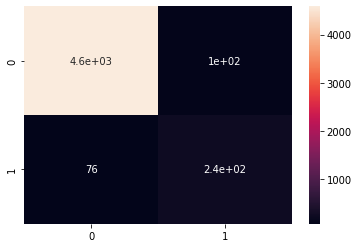

In [15]:
kacak_tahmin_modeli(random_sample = 17, model_df = train_testData, validation_df = valData, threshold = 0.5, oversample = True)